In [5]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 74.5 MB/s eta 0:00:00


In [6]:
# !pip install sympy==1.12

In [7]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import timm
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pydicom

In [8]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [9]:
#########################################
# CONFIG 설정
#########################################
class CONFIG:

    CONTEXT_BLOCK = 'sppf' # aspp(무겁) 또는 sppf(더 가볍)

    DATA_DIR = "/content/drive/MyDrive/Daejeon_Medcoding(2024-12~2025-07)/이미지 프로젝트/data/허혈"
    DICOM_DIR = os.path.join(DATA_DIR, "dicom")
    MASK_DIR = os.path.join(DATA_DIR, "masks")

    MODEL_SAVE_PATH_SENS = "/content/drive/MyDrive/Daejeon_Medcoding(2024-12~2025-07)/이미지 프로젝트/data/허혈/best_model_sens(2.2).pth"
    MODEL_SAVE_PATH_DICE = "/content/drive/MyDrive/Daejeon_Medcoding(2024-12~2025-07)/이미지 프로젝트/data/허혈/best_model_dice(2.2).pth"
    MODEL_TEST_PATH = MODEL_SAVE_PATH_DICE

    TARGET_SIZE = (512, 512)
    BATCH_SIZE = 4
    NUM_EPOCHS = 40
    LEARNING_RATE = 1e-4
    TRAIN_SPLIT = 0.7
    VAL_SPLIT = 0.15
    TEST_SPLIT = 0.15
    NUM_WORKERS = 4
    WEIGHT_DECAY = 1e-5
    SCHEDULER_FACTOR = 0.5
    SCHEDULER_PATIENCE = 3
    FOCAL_ALPHA = 0.8
    FOCAL_GAMMA = 2

In [10]:
#########################################
# Dataset
#########################################
class CTDicomDataset(Dataset):
    def __init__(self, dicom_paths, mask_paths, transform=None, mask_transform=None):
        self.dicom_paths = dicom_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.dicom_paths)

    def __getitem__(self, idx):
        dicom_path = self.dicom_paths[idx]
        mask_path = self.mask_paths[idx]

        ds = pydicom.dcmread(dicom_path)
        image = ds.pixel_array.astype(np.int16)
        slope = float(ds.get('RescaleSlope', 1))
        intercept = float(ds.get('RescaleIntercept', 0))
        image = image * slope + intercept
        image = cv2.resize(image, CONFIG.TARGET_SIZE, interpolation=cv2.INTER_LINEAR)
        image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-8)
        image = np.expand_dims(image, axis=0)
        image = np.repeat(image, 3, axis=0)
        image_tensor = torch.tensor(image, dtype=torch.float32)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, CONFIG.TARGET_SIZE, interpolation=cv2.INTER_NEAREST)
        mask = (mask > 127).astype(np.float32)
        mask = np.expand_dims(mask, axis=0)
        mask_tensor = torch.tensor(mask, dtype=torch.float32)

        if self.transform:
            image_tensor = self.transform(image_tensor)
        if self.mask_transform:
            mask_tensor = self.mask_transform(mask_tensor)

        return image_tensor, mask_tensor

In [4]:
#########################################
# Loss Functions
#########################################
def dice_loss(pred, target, smooth=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    dice = (2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)
    return 1 - dice.mean()

def focal_loss(pred, target, alpha=CONFIG.FOCAL_ALPHA, gamma=CONFIG.FOCAL_GAMMA):
    bce_loss = nn.functional.binary_cross_entropy(pred, target, reduction='none')
    pt = torch.exp(-bce_loss)
    return (alpha * (1 - pt) ** gamma * bce_loss).mean()

def combined_loss(pred, target, alpha=0.3):
    return (1 - alpha) * dice_loss(pred, target) + alpha * focal_loss(pred, target)

In [11]:
#########################################
# Metrics
#########################################
def compute_metrics(pred, target, threshold=0.7, smooth=1e-6):
    pred_bin = (pred > threshold).float()
    TP = (pred_bin * target).sum()
    FP = (pred_bin * (1 - target)).sum()
    FN = ((1 - pred_bin) * target).sum()
    TN = ((1 - pred_bin) * (1 - target)).sum()

    dice = (2 * TP + smooth) / (2 * TP + FP + FN + smooth)
    iou = TP / (TP + FP + FN + smooth)
    sensitivity = TP / (TP + FN + smooth)
    specificity = TN / (TN + FP + smooth)
    precision = TP / (TP + FP + smooth)
    f1 = 2 * precision * sensitivity / (precision + sensitivity + smooth)
    return {
        'dice': dice.item(),
        'iou': iou.item(),
        'sensitivity': sensitivity.item(),
        'specificity': specificity.item(),
        'precision': precision.item(),
        'f1_score': f1.item()
    }

In [12]:
#########################################
# Model Architecture: Swin Lite Segmentation (with Lightweight Decoder) #
#########################################
"""
기존의 간단한 구조에 조금 추가
[Skip Feature] → [Conv2d (1x1)] → [SE Block] → [DepthwiseConv] → [PointwiseConv] → [UpSample] → [Fusion]
"""

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=6, dilation=6)
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=12, dilation=12)
        self.conv4 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=18, dilation=18)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.conv_global = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.out_conv = nn.Conv2d(out_channels * 5, out_channels, kernel_size=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        x4 = self.conv4(x)
        x5 = self.global_pool(x)
        x5 = self.conv_global(x5)
        x5 = F.interpolate(x5, size=x4.size()[2:], mode='bilinear', align_corners=False)
        x = torch.cat((x1, x2, x3, x4, x5), dim=1)
        x = self.out_conv(x)
        return self.relu(x)


class SPPF(nn.Module):
    def __init__(self, in_channels, out_channels, pool_size=5):
        super(SPPF, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, kernel_size=1)
        self.pool = nn.MaxPool2d(kernel_size=pool_size, stride=1, padding=pool_size // 2)
        self.conv2 = nn.Conv2d(out_channels * 2, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.conv1(x)
        y1 = self.pool(x)
        y2 = self.pool(y1)
        y3 = self.pool(y2)
        x = torch.cat([x, y1, y2, y3], dim=1)
        return self.conv2(x)


class SwinLiteSegmentation(nn.Module):
    def __init__(self, num_classes=1, context_block=CONFIG.CONTEXT_BLOCK):  # <- 여기!
        super(SwinLiteSegmentation, self).__init__()
        self.backbone = timm.create_model(
            'swin_tiny_patch4_window7_224',
            pretrained=True,
            features_only=True,
            out_indices=(0, 1, 2, 3),
            img_size=CONFIG.TARGET_SIZE[0]
        )
        backbone_channels = self.backbone.feature_info.channels()
        self.conv3 = nn.Conv2d(backbone_channels[-1], 256, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(backbone_channels[-2], 256, kernel_size=3, padding=1)
        self.conv1 = nn.Conv2d(backbone_channels[-3], 256, kernel_size=3, padding=1)
        self.conv0 = nn.Conv2d(backbone_channels[-4], 256, kernel_size=3, padding=1)

        # Context Module 선택
        if context_block == 'aspp':
            self.context = ASPP(256, 256)
        elif context_block == 'sppf':
            self.context = SPPF(256, 256)
        else:
            self.context = nn.Identity()

        self.seg_head = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, num_classes, kernel_size=1)
        )

    def forward(self, x):
        features = self.backbone(x)
        expected_channels = self.backbone.feature_info.channels()[0]
        if features[0].shape[1] != expected_channels:
            features = [f.permute(0, 3, 1, 2) for f in features]

        x = self.conv3(features[-1])
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = x + self.conv2(features[-2])
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = x + self.conv1(features[-3])
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = x + self.conv0(features[-4])

        x = F.interpolate(x, scale_factor=4, mode='bilinear', align_corners=False)
        x = self.context(x)
        x = self.seg_head(x)
        return torch.sigmoid(x)

                 ┌────────────┐
                 │ Input (3x512x512)
                 └────┬───────┘
                      ↓
          ┌────────────────────┐
          │ Swin Tiny Backbone │
          └────┬────┬────┬─────┘
               ↓    ↓    ↓
          [Stage 0 ~ Stage 3 Features]  →→→→→→→→
                         ↓
                ┌─────────────────────┐
                │ Decoder (UpBlock ×4)│
                │ + SE + DepthwiseConv│
                └──────────┬──────────┘
                           ↓
                 ┌───────────────────┐
                 │ Segmentation Head │
                 │ Conv → ReLU → 1x1 │
                 └──────────┬────────┘
                           ↓
                         Sigmoid
                           ↓
                        Output Mask


In [13]:
#########################################
# Validation
#########################################
def validate(model, dataloader, device):
    model.eval()
    loss_sum = 0.0
    metrics_list = []
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            loss = combined_loss(outputs, masks)
            loss_sum += loss.item()
            metrics_list.append(compute_metrics(outputs, masks))
    avg_loss = loss_sum / len(dataloader)
    avg_metrics = {k: np.mean([m[k] for m in metrics_list]) for k in metrics_list[0]}
    return avg_loss, avg_metrics

In [14]:
def split_dicom_mask_files():
    dicom_files = sorted([os.path.join(CONFIG.DICOM_DIR, f) for f in os.listdir(CONFIG.DICOM_DIR) if f.endswith('.dcm')])
    mask_files = sorted([os.path.join(CONFIG.MASK_DIR, f) for f in os.listdir(CONFIG.MASK_DIR) if f.endswith('.png')])

    train_dicoms, temp_dicoms, train_masks, temp_masks = train_test_split(
        dicom_files, mask_files, test_size=(1 - CONFIG.TRAIN_SPLIT), random_state=42)
    val_size = CONFIG.VAL_SPLIT / (CONFIG.VAL_SPLIT + CONFIG.TEST_SPLIT)
    val_dicoms, test_dicoms, val_masks, test_masks = train_test_split(
        temp_dicoms, temp_masks, test_size=(1 - val_size), random_state=42)

    return train_dicoms, train_masks, val_dicoms, val_masks, test_dicoms, test_masks

In [15]:
#########################################
# Training Loop Functions               #
#########################################
def train_infarct_model(train_dicoms, train_masks, val_dicoms, val_masks):
    """
    전체 학습 파이프라인 수행:
    - train/val 성능 기록 및 모델 저장
    - loss, dice 그래프 출력
    """
    train_dataset = CTDicomDataset(train_dicoms, train_masks)
    val_dataset = CTDicomDataset(val_dicoms, val_masks)
    train_loader = DataLoader(train_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=True, num_workers=CONFIG.NUM_WORKERS)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=False, num_workers=CONFIG.NUM_WORKERS)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SwinLiteSegmentation(num_classes=1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=CONFIG.LEARNING_RATE, weight_decay=CONFIG.WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                     factor=CONFIG.SCHEDULER_FACTOR,
                                                     patience=CONFIG.SCHEDULER_PATIENCE,
                                                     verbose=True)

    best_val_dice = 0.0
    best_val_sens = 0.0
    train_losses, val_losses = [], []
    train_dices, val_dices = [], []
    train_sens, val_sens = [], []

    for epoch in range(CONFIG.NUM_EPOCHS):
        model.train()
        epoch_loss = 0.0
        metrics_train = []
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = combined_loss(outputs, masks)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            metrics_train.append(compute_metrics(outputs, masks))

        avg_train_loss = epoch_loss / len(train_loader)
        avg_train_dice = np.mean([m['dice'] for m in metrics_train])
        avg_train_sens = np.mean([m['sensitivity'] for m in metrics_train])

        train_losses.append(avg_train_loss)
        train_dices.append(avg_train_dice)
        train_sens.append(avg_train_sens)

        val_loss, val_metrics = validate(model, val_loader, device)
        val_losses.append(val_loss)
        val_dices.append(val_metrics['dice'])
        val_sens.append(val_metrics['sensitivity'])

        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{CONFIG.NUM_EPOCHS}")
        print(f" Train Loss: {avg_train_loss:.4f} | Dice: {avg_train_dice:.4f} | Sensitivity: {avg_train_sens:.4f}")
        print(f" Val   Loss: {val_loss:.4f} | Dice: {val_metrics['dice']:.4f} | Sensitivity: {val_metrics['sensitivity']:.4f}")

        if val_metrics['sensitivity'] > best_val_sens:
            best_val_sens = val_metrics['sensitivity']
            torch.save(model.state_dict(), CONFIG.MODEL_SAVE_PATH_SENS)
            print("=> Saved best sensitivity model")

        if val_metrics['dice'] > best_val_dice:
            best_val_dice = val_metrics['dice']
            torch.save(model.state_dict(), CONFIG.MODEL_SAVE_PATH_DICE)
            print("=> Saved best Dice model")
        print("-" * 80)

    # 학습 곡선 시각화
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_dices, label="Train Dice")
    plt.plot(val_dices, label="Val Dice")
    plt.title("Training vs Validation Dice")
    plt.xlabel("Epoch")
    plt.ylabel("Dice")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [16]:
#########################################
# 테스트셋 평가 및 시각화 함수          #
#########################################
def evaluate_on_testset(model, test_loader, device):
    model.load_state_dict(torch.load(CONFIG.MODEL_TEST_PATH, map_location=device))
    model.to(device)
    model.eval()

    test_loss, metrics = validate(model, test_loader, device)
    print("\n[Best Model 기준] 테스트셋 성능 평가")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Dice: {metrics['dice']:.4f} | IoU: {metrics['iou']:.4f} | Sensitivity: {metrics['sensitivity']:.4f} |")
    print(f"Specificity: {metrics['specificity']:.4f} | Precision: {metrics['precision']:.4f} | F1-score: {metrics['f1_score']:.4f}")

    sample_count = 0
    with torch.no_grad():
        for test_images, test_masks in test_loader:
            test_images = test_images.to(device)
            test_masks = test_masks.to(device)
            preds = model(test_images)
            preds_bin = (preds > 0.5).float()

            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[0][0].cpu(), cmap='gray')
            plt.title("Input")
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(test_masks[0][0].cpu(), cmap='gray')
            plt.title("GT Mask")
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(preds_bin[0][0].cpu(), cmap='gray')
            plt.title("Predicted")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

            sample_count += 1
            if sample_count >= 3:
                break

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/40
 Train Loss: 0.4861 | Dice: 0.4072 | Sensitivity: 0.5303
 Val   Loss: 0.4184 | Dice: 0.5429 | Sensitivity: 0.5584
=> Saved best sensitivity model
=> Saved best Dice model
--------------------------------------------------------------------------------
Epoch 2/40
 Train Loss: 0.3838 | Dice: 0.5669 | Sensitivity: 0.6415
 Val   Loss: 0.3870 | Dice: 0.5639 | Sensitivity: 0.7030
=> Saved best sensitivity model
=> Saved best Dice model
--------------------------------------------------------------------------------
Epoch 3/40
 Train Loss: 0.3391 | Dice: 0.6173 | Sensitivity: 0.6733
 Val   Loss: 0.3703 | Dice: 0.6079 | Sensitivity: 0.6209
=> Saved best Dice model
--------------------------------------------------------------------------------
Epoch 4/40
 Train Loss: 0.2935 | Dice: 0.6796 | Sensitivity: 0.7164
 Val   Loss: 0.3461 | Dice: 0.6089 | Sensitivity: 0.7496
=> Saved best sensitivity model
=> Saved best Dice model
-------------------------------------------------------------

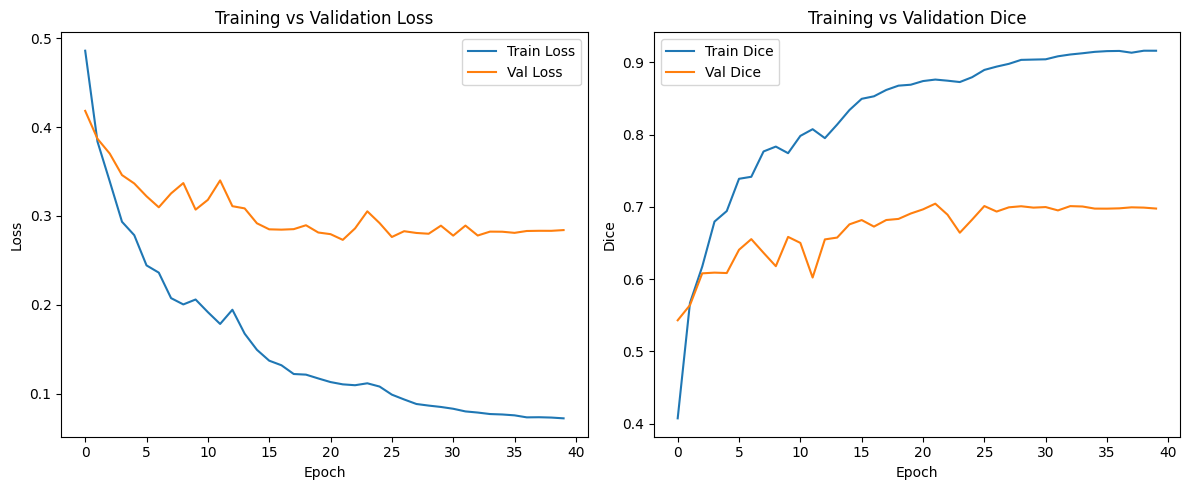

In [14]:
if __name__ == "__main__":
    # 데이터 분할
    train_dicoms, train_masks, val_dicoms, val_masks, test_dicoms, test_masks = split_dicom_mask_files()

    # 학습 실행
    train_infarct_model(train_dicoms, train_masks, val_dicoms, val_masks)

    # 테스트용 모델 로딩 및 평가 따로 가능

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]


[Best Model 기준] 테스트셋 성능 평가
Test Loss: 0.2974
Dice: 0.5986 | IoU: 0.4901 | Sensitivity: 0.6192 |
Specificity: 0.9959 | Precision: 0.6400 | F1-score: 0.5986


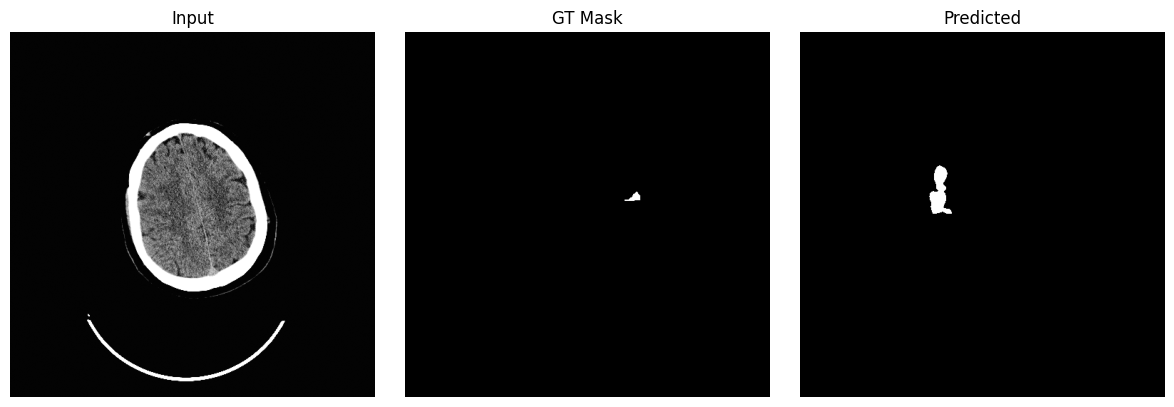

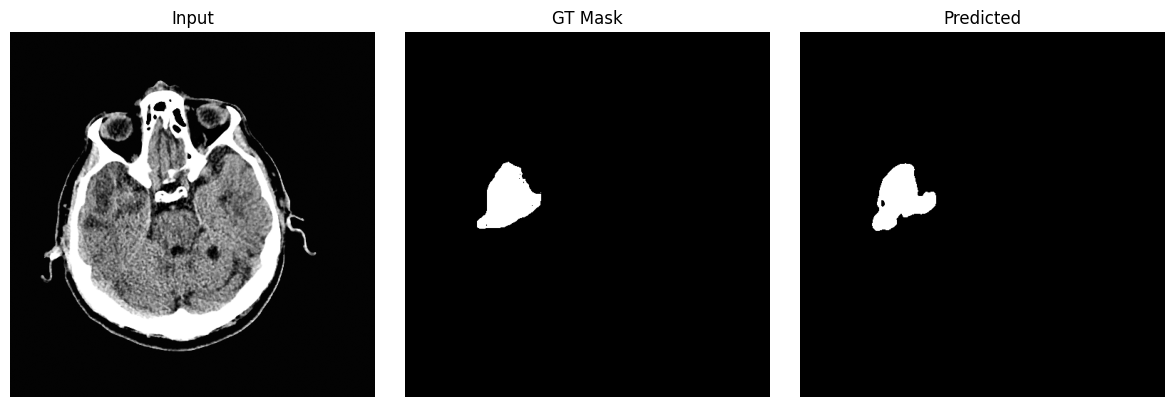

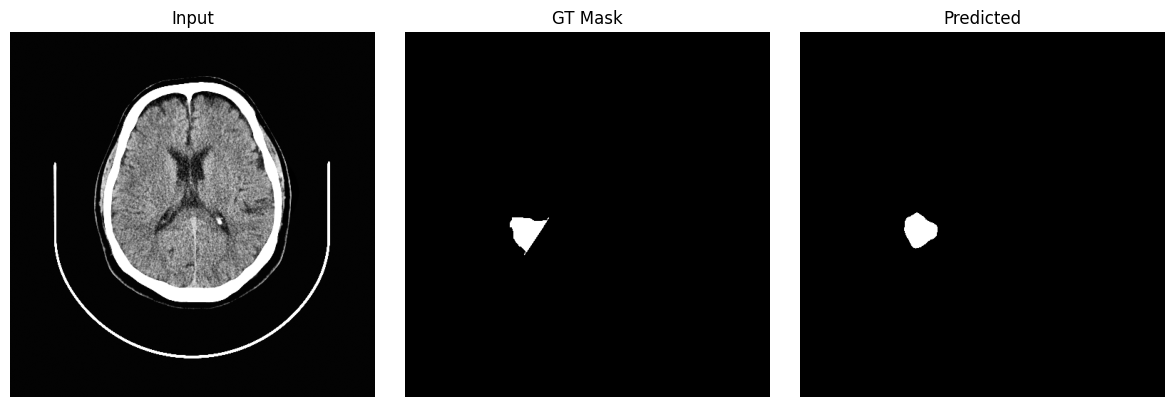

In [17]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 분할 한 번만!
    train_dicoms, train_masks, val_dicoms, val_masks, test_dicoms, test_masks = split_dicom_mask_files()

    # 테스트 (학습 안 해도 테스트 가능!)
    test_dataset = CTDicomDataset(test_dicoms, test_masks)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=CONFIG.NUM_WORKERS)

    model = SwinLiteSegmentation(num_classes=1, context_block=CONFIG.CONTEXT_BLOCK)
    model.load_state_dict(torch.load(CONFIG.MODEL_TEST_PATH, map_location=device))
    model.to(device)

    evaluate_on_testset(model, test_loader, device)